In [2]:
import sys
sys.path.append("../")

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial

import torch
from torchvision.transforms import ToTensor, Compose, Lambda
from torch.utils.data import DataLoader
from torchvision import datasets

In [4]:
from MultilabelKernelPerceptron import MultilabelKernelPerceptron
from KMeans import DATASET_LOCATION, DEVICE
from MNIST import mnist_loader, label_set
from utils import polynomial, sgn_label, sgn

## Load the data

In [6]:
training_batch_size = 60_000
test_batch_size = 10_000

train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor()])
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=Compose([ToTensor()])
)

train_dataloader = DataLoader(train_data, batch_size=training_batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=test_batch_size, shuffle=True)

train_examples = iter(train_dataloader)
test_examples = iter(test_dataloader)

x_train, y_train = next(train_examples)
x_test, y_test = next(test_examples)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## Sample

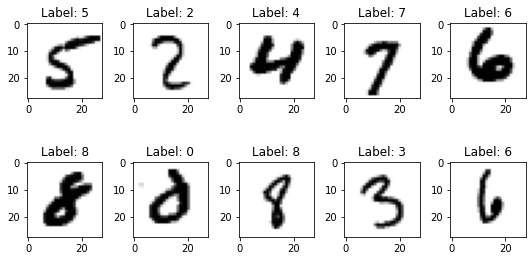

In [24]:
num = 10
images = x_train[:num]
labels = y_train[:num]

rows = 2
cols = 5
fig, axes = plt.subplots(rows, cols, figsize=(1.5 * cols, 2 * rows))

for i in range(num):
    ax = axes[i // cols, i % cols]
    ax.imshow(images[i][0], cmap='gray_r')
    ax.set_title(f"Label: {labels[i]}")
    
plt.tight_layout()
plt.show()

## Run the algorithm with the 1500 reduction

In [17]:
x_train_km = torch.load(f"../{DATASET_LOCATION}/1500/x_train_km.pt")
y_train_km = torch.load(f"../{DATASET_LOCATION}/1500/y_train_km.pt")

mkp = MultilabelKernelPerceptron(partial(polynomial, degree=5), label_set, 5, x_train_km, y_train_km, DEVICE)

In [18]:
%%time
mkp.fit()

CPU times: user 2.41 s, sys: 28 ms, total: 2.44 s
Wall time: 2.27 s


In [19]:
def classify(model, digit):
    digit = digit.reshape((-1, ))
    kernel_matrix = polynomial(digit, x_train_km.T)
    scores = [torch.sum(kernel_matrix * sgn_label(y_train_km, label) * alpha, 0)
              for label, alpha in enumerate(model)]
    return torch.max(torch.stack(scores), 0)[1]

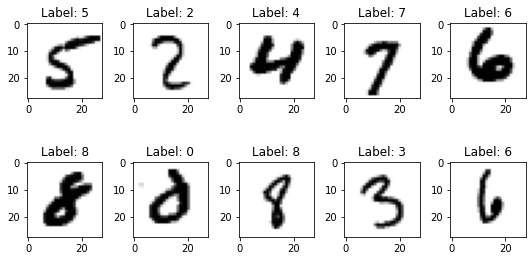

In [21]:
fig, axes = plt.subplots(rows, cols, figsize=(1.5 * cols, 2 * rows))

for i in range(num):
    prediction = classify(mkp.model, images[i][0])
    
    ax = axes[i // cols, i % cols]
    ax.imshow(images[i][0], cmap="gray_r")
    ax.set_title(f"Label: {prediction}")
    
plt.tight_layout()
plt.show()